In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np

# 1.1. Collect credit card transaction data
df = pd.read_csv('multi_touch_attribution_data.csv')

# Drop customerID since it's not useful for modeling
#df = df.drop(columns=['customerID'], errors='ignore')

# cast variables where it makes sense
#df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
#df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')

df_temp = df.copy()
df_temp.columns = [f"{col}, {idx}, {df_temp[col].nunique()}" for idx, col in enumerate(df_temp.columns)]

from IPython.display import display
display(df_temp)
#print(df_temp.head(5))
del df_temp

,"User ID, 0, 2847","Timestamp, 1, 9737","Channel, 2, 6","Campaign, 3, 6","Conversion, 4, 2"
0,83281,2025-02-10 07:58:51,Email,New Product Launch,No
1,68071,2025-02-10 23:38:48,Search Ads,Winter Sale,No
2,90131,2025-02-11 10:41:07,Social Media,Brand Awareness,Yes
3,71026,2025-02-10 08:19:44,Direct Traffic,-,Yes
4,94486,2025-02-10 15:15:46,Email,Retargeting,Yes
...,...,...,...,...,...
9995,24161,2025-02-11 10:13:56,Display Ads,New Product Launch,No
9996,17611,2025-02-11 10:26:38,Email,-,No
9997,78374,2025-02-11 21:52:47,Email,Brand Awareness,No
9998,22741,2025-02-11 06:30:13,Search Ads,Winter Sale,No


In [2]:
##Handle missing values and outliers
#
# If missing values are few → Fill with median (less affected by outliers).
# If missing values are many → Fill with mean (if data is normally distributed).
#df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())  # Use median for robustness as only 11 values missing
#
# If the missing category means “No Service” (e.g., MultipleLines_No phone service) → Fill with "No".
# Otherwise, fill with the most frequent category (mode).
# df['PaymentMethod'] = df['PaymentMethod'].fillna(df['PaymentMethod'].mode()[0])
# df['InternetService'] = df['InternetService'].fillna("No")  # If it makes logical sense
#
# If missing values are random and small in number, dropping rows may be an option:
# df.dropna(inplace=True)



In [3]:
# 1.3. Perform exploratory data analysis (EDA)
eda_df = pd.DataFrame({
    'DType': df.dtypes,
    'Rows': df.shape[0],
    'Values': df.count(),
    'Unique': df.nunique(),
    'Miss': df.isnull().sum(),
    'Null': (df.isnull().sum() / len(df)) * 100,
    'min': df.describe().transpose()['min'].round(2),
    'max': df.describe().transpose()['max'].round(2),
    'mean': df.describe().transpose()['mean'].round(2),
    'sd': df.describe().transpose()['std'].round(2),
}).reindex(df.columns, axis=0)

eda_df.insert(0, 'Column Number', range(0, len(eda_df) ))
eda_df['Sample'] = df.iloc[:3].apply(lambda row: ', '.join(row.astype(str)), axis=0)
eda_df['Encoding'] = df.apply(lambda col: 'label' if col.dtype == 'object' and col.nunique() == 2
                          else ('one-hot' if col.dtype == 'object' and col.nunique() > 2 else 'none'), axis=0)
display(eda_df)
del eda_df

,Column Number,DType,Rows,Values,Unique,Miss,Null,min,max,mean,sd,Sample,Encoding
User ID,0,int64,10000,10000,2847,0,0.0,10028.0,99995.0,54957.02,25685.15,"83281, 68071, 90131",none
Timestamp,1,object,10000,10000,9737,0,0.0,NaN,NaN,NaN,NaN,"2025-02-10 07:58:51, 2025-02-10 23:38:48, 2025...",one-hot
Channel,2,object,10000,10000,6,0,0.0,NaN,NaN,NaN,NaN,"Email, Search Ads, Social Media",one-hot
Campaign,3,object,10000,10000,6,0,0.0,NaN,NaN,NaN,NaN,"New Product Launch, Winter Sale, Brand Awareness",one-hot
Conversion,4,object,10000,10000,2,0,0.0,NaN,NaN,NaN,NaN,"No, No, Yes",label


In [4]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Convert the timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [6]:
# Encode categorical variables
df['Channel'] = df['Channel'].astype('category').cat.codes
df['Campaign'] = df['Campaign'].astype('category').cat.codes
df['Conversion'] = df['Conversion'].map({'Yes': 1, 'No': 0})

In [7]:
df.head(10)

,User ID,Timestamp,Channel,Campaign,Conversion
0,83281,2025-02-10 07:58:51,2,3,0
1,68071,2025-02-10 23:38:48,4,5,0
2,90131,2025-02-11 10:41:07,5,1,1
3,71026,2025-02-10 08:19:44,0,0,1
4,94486,2025-02-10 15:15:46,2,4,1
5,31134,2025-02-11 06:43:06,4,0,1
6,99995,2025-02-10 06:15:30,4,0,1
7,45832,2025-02-11 01:09:27,3,5,1
8,79863,2025-02-10 06:48:56,1,2,1
9,35324,2025-02-10 21:36:24,0,0,0


In [8]:
# Sort the data by User ID and Timestamp
df = df.sort_values(by=['User ID', 'Timestamp'])

In [9]:
# Create features
df['Interaction_Count'] = df.groupby('User ID').cumcount() + 1

In [10]:
df.head(10)

,User ID,Timestamp,Channel,Campaign,Conversion,Interaction_Count
8297,10028,2025-02-10 01:44:12,4,2,1,1
3633,10028,2025-02-11 01:03:57,1,0,1,2
9486,10045,2025-02-10 17:20:43,4,2,0,1
7663,10045,2025-02-11 18:44:15,1,3,1,2
8643,10062,2025-02-10 15:42:42,5,1,0,1
7029,10062,2025-02-10 22:00:18,0,0,0,2
1967,10062,2025-02-11 21:10:27,2,1,1,3
2080,10068,2025-02-10 07:07:39,4,0,1,1
8457,10068,2025-02-11 08:05:04,5,4,0,2
9490,10068,2025-02-11 10:14:02,5,1,1,3


In [11]:
# Aggregate data at the user level
user_data = df.groupby('User ID').agg({
    'Channel': 'sum',
    'Campaign': 'sum',
    'Interaction_Count': 'max',
    'Conversion': 'max'
}).reset_index()

In [12]:
user_data.head()

,User ID,Channel,Campaign,Interaction_Count,Conversion
0,10028,5,2,2,1
1,10045,5,5,2,1
2,10062,7,2,3,1
3,10068,23,13,5,1
4,10095,14,15,6,1


In [13]:
# Define features and target variable
X = user_data[['Channel', 'Campaign', 'Interaction_Count']]
y = user_data['Conversion']

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression

In [15]:
# Initialize the logistic regression model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

In [16]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.84


In [17]:
# Display confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  0 138]
 [  0 717]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       138
           1       0.84      1.00      0.91       717

    accuracy                           0.84       855
   macro avg       0.42      0.50      0.46       855
weighted avg       0.70      0.84      0.76       855



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
# Get the model coefficients
coefficients = model.coef_.flatten()
feature_names = X.columns

In [19]:
# Create a DataFrame to display the coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
print(coef_df)

             Feature  Coefficient
0            Channel    -0.006792
1           Campaign    -0.022761
2  Interaction_Count     0.836227


Positive Coefficient: Indicates that as the value of the feature increases, the likelihood of conversion also increases.

The positive coefficient for the "Interaction_Count" feature suggests that the more interactions a user has,
the higher the likelihood of conversion. This implies that repeated engagements with the user increase the chances of them converting.

In this case, coefficient is 0.83 for Interaction_Count. This means that for each additional interaction, the odds of conversion increase by a factor of (e^{0.83}), which is approximately 2.3

# XGBoost

In [20]:
# Initialize the XGBoost model
model = XGBClassifier()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


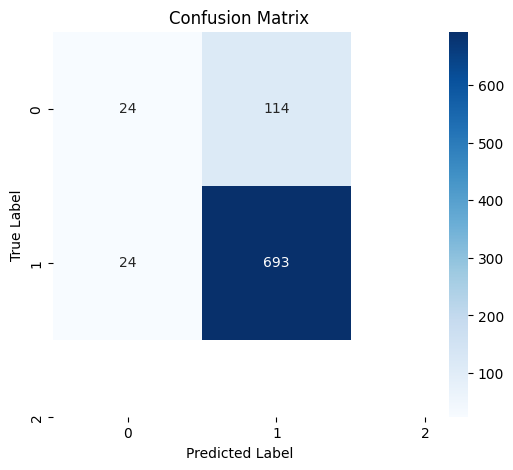

In [21]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualizing with a heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [22]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.84


In [23]:
# Display confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 24 114]
 [ 24 693]]
              precision    recall  f1-score   support

           0       0.50      0.17      0.26       138
           1       0.86      0.97      0.91       717

    accuracy                           0.84       855
   macro avg       0.68      0.57      0.58       855
weighted avg       0.80      0.84      0.80       855



In [24]:
# Get the feature importances
importances = model.feature_importances_
feature_names = X.columns

In [25]:
# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(importance_df)

             Feature  Importance
0            Channel    0.129971
1           Campaign    0.116160
2  Interaction_Count    0.753869


Coefficient for Interaction_count is 0.75.
This means that for each additional interaction, the odds of conversion increase by approximately 2.12 times.

### **What is the optimal number of interactions before a user is likely to convert?**

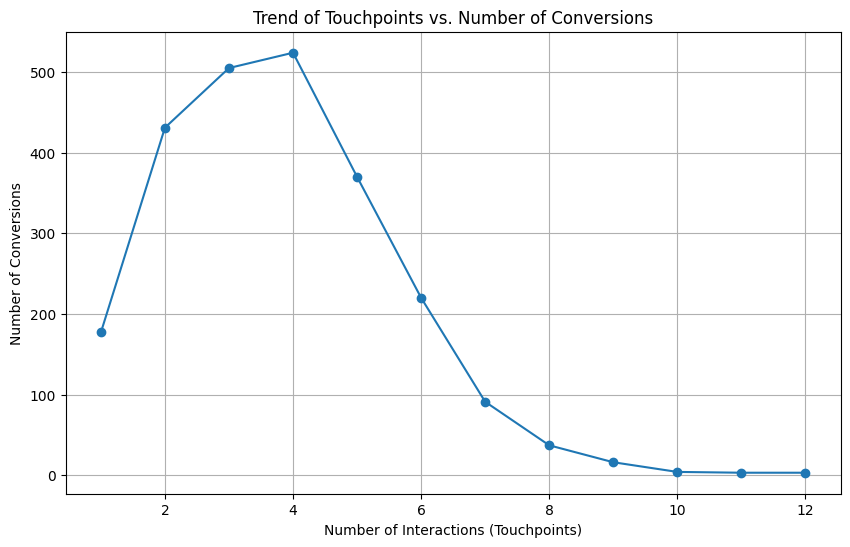

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the Conversion column is binary (already done in dataset)
user_data['Conversion'] = user_data['Conversion'].astype(int)

# Aggregate to count the number of conversions per Interaction_Count
touchpoint_trend = user_data.groupby("Interaction_Count")["Conversion"].sum()

# Plot Number of Touchpoints vs. Number of Conversions
plt.figure(figsize=(10, 6))
plt.plot(touchpoint_trend.index, touchpoint_trend.values, marker='o', linestyle='-')
plt.xlabel("Number of Interactions (Touchpoints)")
plt.ylabel("Number of Conversions")
plt.title("Trend of Touchpoints vs. Number of Conversions")
plt.grid()

# Show the plot
plt.show()